In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
import os

In [2]:
species_index = pd.read_pickle('results_GG/species_index.pkl')
species_index_T = pd.Series(species_index)
species_index_T = pd.Series(species_index_T.index, index = species_index_T.values)
species_index_T = species_index_T.to_dict()

# abundances = pd.read_pickle('GAM_species/species_fit_140_0.01.pkl')
abundances = pd.read_pickle('../data_GG/GAM/species_fit_301_0.01.pkl')

In [4]:
data_path = './results_GG/transfer_entropies'
p_values_list = []

windows = [0, 20, 40, 60, 80, 100]
window_width = 40

windows = [0, 50, 100, 150, 200]
window_width = 100

for idx,start in enumerate(windows):
    end = start + window_width
    # Load the data
    original_table = pd.read_pickle(f'{data_path}/original_table_{start}:{end}.pkl')

    tables = []
    for i in range(0,1000):
        filename = f"TE_matrix{i}_{start}:{end}.pkl"
        filepath = os.path.join(data_path, filename)
        if os.path.exists(filepath):
            tables.append(pd.read_pickle(f'{data_path}/{filename}'))
    print(len(tables))

    p_values_list.append(np.zeros(original_table.shape))
    for table in tables:
        p_values_list[idx] += (original_table.values < table.values).astype(int)
    p_values_list[idx] /= len(tables)
    p_values_list[idx][np.eye(p_values_list[idx].shape[0], dtype=bool)] = np.nan

1000
1000
1000
1000
1000


In [58]:
import networkx as nx

# grab the top L edges
L = 100
graphs = []

for idx, start in enumerate(windows):
    end = start + window_width

    cut_value = np.sort(p_values_list[idx].flatten())[L]
    cut_value = 0.05
    print(cut_value)
    adjacency = (p_values_list[idx] <= cut_value).astype(int)
    graphs.append(nx.from_numpy_array(adjacency, create_using=nx.DiGraph))

0.05
0.05
0.05
0.05
0.05


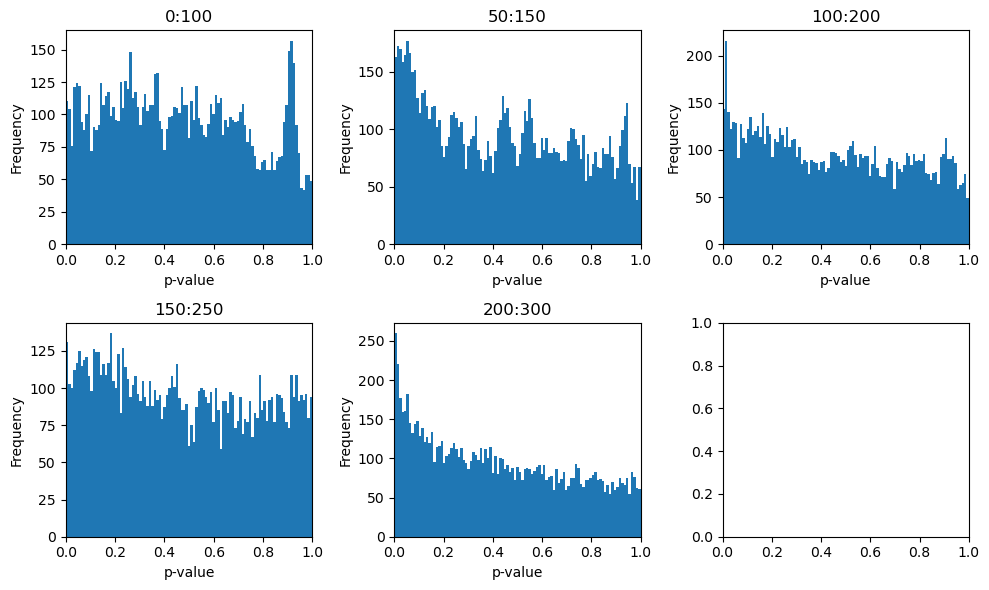

In [56]:
fig,axes = plt.subplots(2,3,figsize=(10, 6))
for idx,graph in enumerate(graphs):
    ax = axes.flatten()[idx]
    ax.hist(p_values_list[idx].flatten(), bins = int(101))
    ax.set_xlabel('p-value')
    ax.set_ylabel('Frequency')
    start = windows[idx]
    end = start + window_width
    ax.set_title(f'{start}:{end}')
    ax.set_xlim(0,1)
fig.set_tight_layout(True)

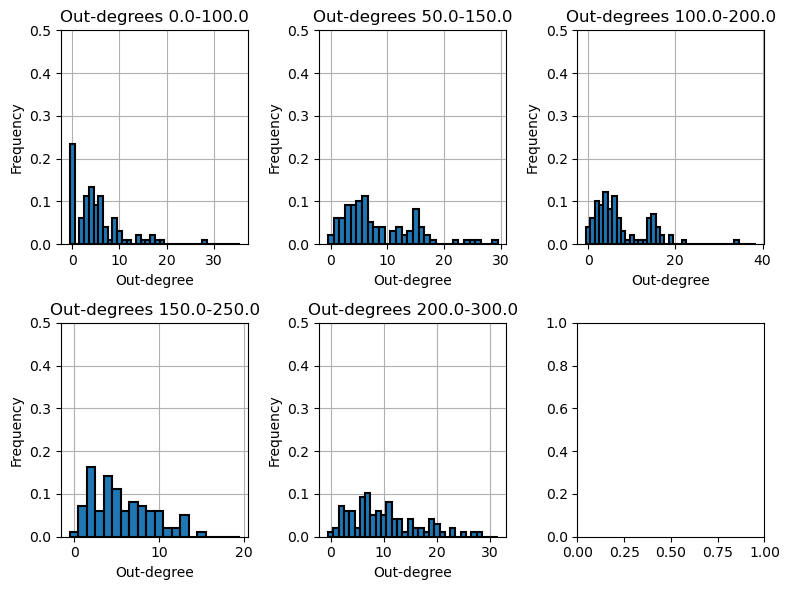

In [62]:
# calculate out-degree distributions

fig, axes = plt.subplots(2, 3, figsize=(8, 6))
degree_distributions = []
for idx, graph in enumerate(graphs):
    out_degree = np.array([graph.out_degree(n) for n in graph.nodes()])
    degree_distributions.append(out_degree)
    # plot the degree distributions
    ax = axes.flatten()[idx]
    ax.grid()
    ax.hist(out_degree, histtype='bar', bins=np.arange(-0.5, out_degree.max()+0.5, 1),
            density=True, zorder=3,
            edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Out-degree')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Out-degrees {idx*(window_width/2)}-{idx*(window_width/2)+(window_width)}')
    ax.set_ylim(0,0.5)

fig.set_tight_layout(True)

In [34]:
import graph_tool.all as gt


# Function that returns a generator for sequential colormap colors
def sequential_color_generator(cmap_name='tab10'):
    cmap = plt.get_cmap(cmap_name)
    index = 0
    while True:
        yield cmap(index % cmap.N)
        index += 1


# Create a graph-tool Graph object from the networkx graph
def SFDP_layout(network):
    g = gt.Graph(directed=False)
    vlist = {}
    for node in network.nodes:
        #add vertex with the same index as in networkx (example: '32848242')
        vlist[node] = g.add_vertex()
        
    for edge in network.edges:
        g.add_edge(vlist[edge[0]], vlist[edge[1]])


    state = gt.minimize_nested_blockmodel_dl(g)
    pos_gt = gt.sfdp_layout(g, groups=state.levels[0].b, gamma=0.001)
    print(state)
    pos = {}
    groups = {}
    generated_colors = {}
    color_gen = sequential_color_generator('tab10')

    for key, value in vlist.items():
        pos[key] = pos_gt[value]
        groups[key] = state.levels[0].b[value]
    for group in set(groups.values()):
        generated_colors[group] = next(color_gen) # np.random.rand(3,)
    colors = [generated_colors[groups[node]] for node in network.nodes]

    return pos, colors

In [35]:

def custom_seismic():
    # Colors: red -> gray -> blue
    colors = [
        (0.0, 'red'),
        (0.4, 'red'),
        (0.5, 'gray'),
        (0.6, 'blue'),
        (1.0, 'blue')
    ]
    return LinearSegmentedColormap.from_list('custom_seismic_gray', colors)

In [36]:
# for every edge in the graph, calculate the correlation between the abundances of the two species
def get_edge_colors_and_widths(graph, abundances, p_values):
    correlations_edges = []
    for edge in graph.edges:
        species1 = species_index_T[edge[0]]
        species2 = species_index_T[edge[1]]
        abundance1 = abundances[species1]['y']
        abundance2 = abundances[species2]['y']
        correlation = np.corrcoef(abundance1, abundance2)[0, 1]
        correlations_edges.append(correlation)
    correlation_edges = np.array(correlations_edges)

    # used for coloring the edges: green if positive correlation, red if negative
    def get_edge_color(correlation):
        if correlation > 0: return 'green'
        else: return 'red'
    edge_colors = [get_edge_color(correlation) for correlation in correlation_edges]
    edge_colors = [custom_seismic()((correlation+1)/2) for correlation in correlation_edges]

    edge_widths = []
    for edge in graph.edges:
        p_value = p_values[edge[0], edge[1]]
        edge_widths.append(1 / (p_value + 0.01)**(0.25))
    edge_widths = np.array(edge_widths)
    return edge_colors, edge_widths

<NestedBlockState object, with base <BlockState object with 99 blocks (1 nonempty), degree-corrected, for graph <Graph object, undirected, with 99 vertices and 997 edges, at 0x7f845e53dd10>, at 0x7f845c889590>, and 8 levels of sizes [(99, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f8466e0bf20>


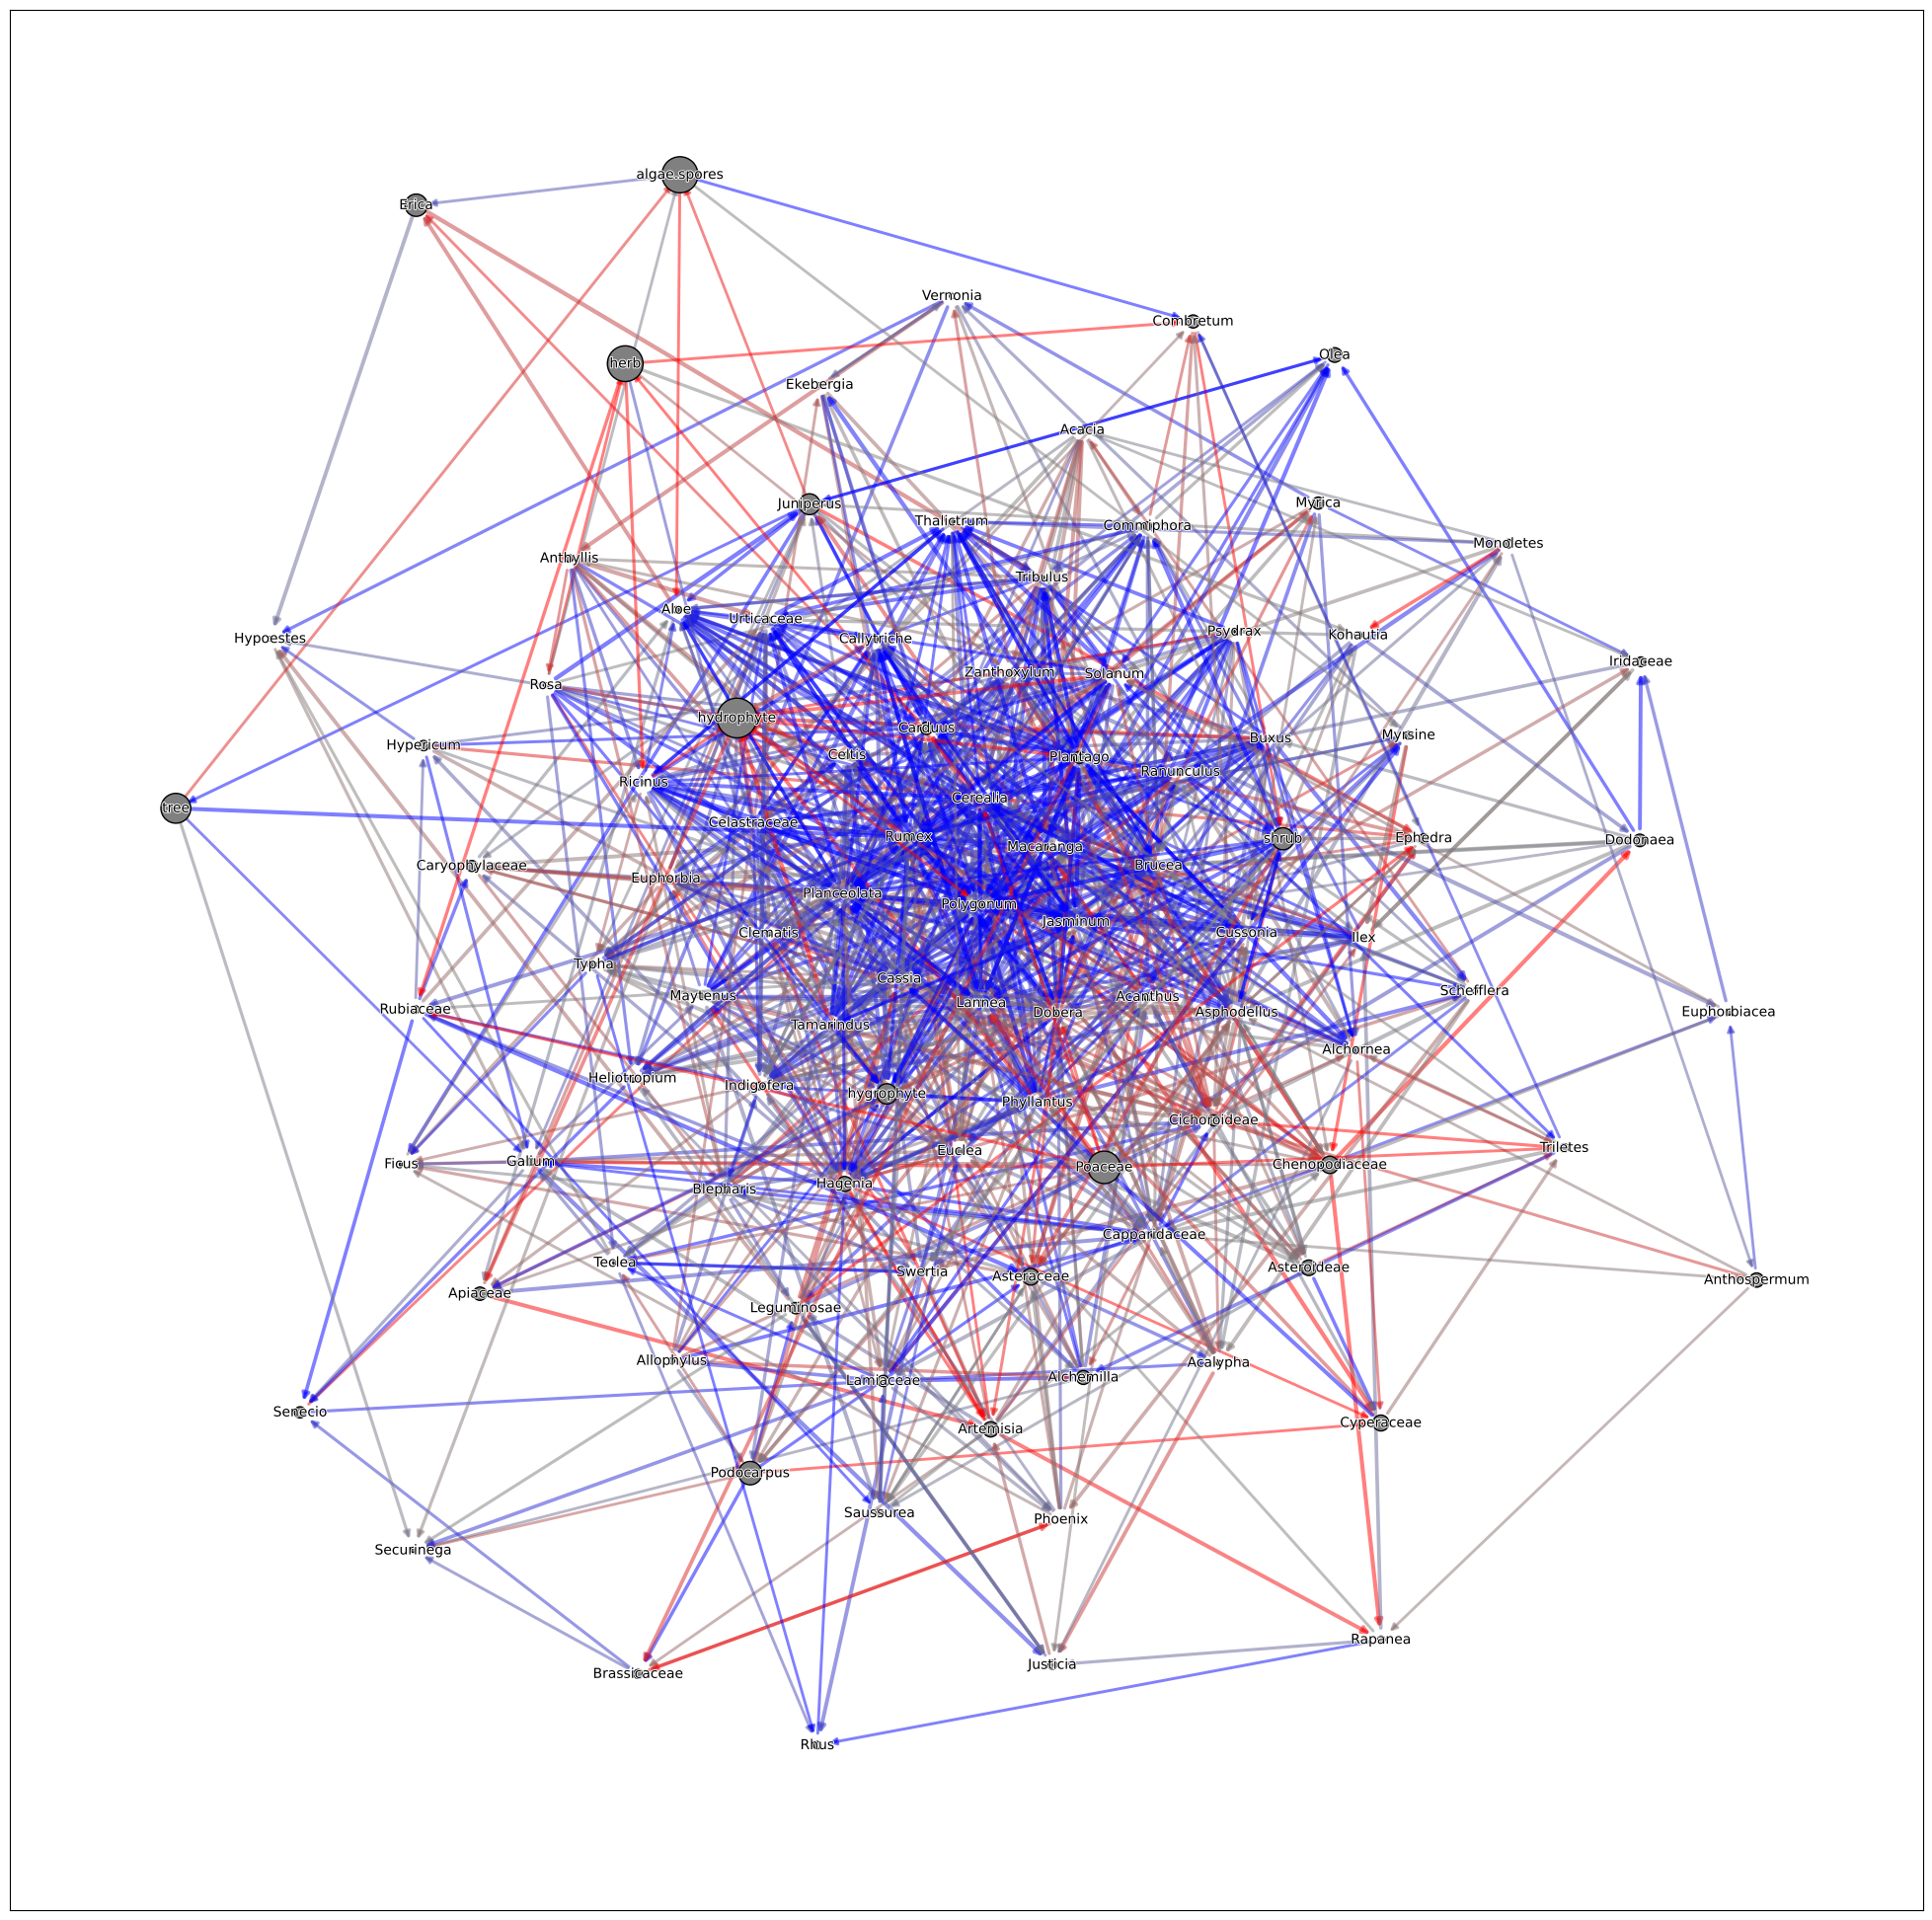

In [59]:
# select graph for visualization
idx = 4
start = idx*(window_width/2)
end = start + window_width

graph = graphs[idx]
p_values = p_values_list[idx]


pos, colors = SFDP_layout(graph)

dict_abundances = {x:abundances[x]['y'].sum() for x in abundances.columns}
sizes = [dict_abundances[species_index_T[x]] for x in graph.nodes]

edge_colors, edge_widths = get_edge_colors_and_widths(graph, abundances, p_values)

fig,ax = plt.subplots(figsize=(25, 25))

nx.draw_networkx_nodes(graph, ax = ax, node_size=[np.sqrt(size)*5 for size in sizes], node_color='grey', pos=pos, edgecolors='black', linewidths=1, alpha=1)

nx.draw_networkx_edges(graph, ax = ax, alpha = 0.5, pos=pos, width=edge_widths, edge_color=edge_colors)

texts = nx.draw_networkx_labels(graph, ax = ax, font_size=10, labels=species_index_T,
                        pos=pos, font_color='black', font_family='sans-serif');

for text in texts.values():
    text.set_path_effects([path_effects.Stroke(linewidth=1.3, foreground='white'),
                       path_effects.Normal()])

# fig.savefig(f'results_GG/TE_networks/TE_network_{start}-{end}.pdf', dpi=300, bbox_inches='tight')

In [61]:
for i in range(0,len(graphs)-1):
    edg1 = set(graphs[i].edges)
    edg2 = set(graphs[i+1].edges)
    temporality = 1. - (1. - len(edg1 & edg2) / len(edg1 | edg2))
    # print(f'Intersection of edges at {i*20+20}: {len(edg1 & edg2)}')
    # print(f'Union of edges at {i*20+20}: {len(edg1 | edg2)}')
    print(f'1 - temporality at {i*(window_width/2)+window_width}: {temporality:.4f}')
    

1 - temporality at 100.0: 0.0320
1 - temporality at 150.0: 0.0907
1 - temporality at 200.0: 0.0655
1 - temporality at 250.0: 0.0585


In [58]:
# highest degrees

degrees = pd.DataFrame(graph.out_degree(), columns=['node', 'degree'])
degrees['node'] = degrees['node'].map(species_index_T)
degrees.sort_values(by='degree', ascending=False, inplace=True)
degrees

,node,degree
33,Lonicera,9
7,Carpinus,3
43,Rubiaceae,3
49,Gentiana,3
31,Ilex_aquifolium,3
...,...,...
106,Polypodium,0
109,Botrychium,0
107,Monolete_ornametnada,0
110,Osmunda,0


Text(0, 0.5, 'Frequency')

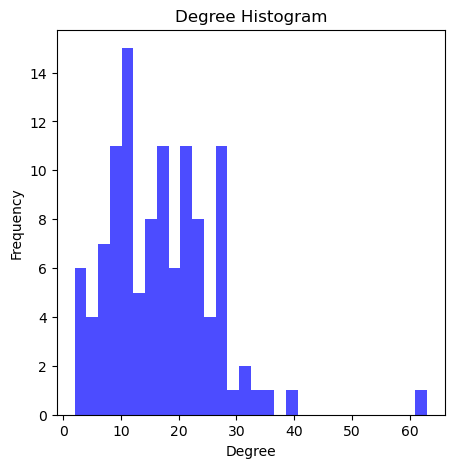

In [46]:
# degree distribution

plt.figure(figsize=(5, 5))
plt.hist(degrees['degree'], bins=30, color='blue', alpha=0.7)
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")

Berberidaceae


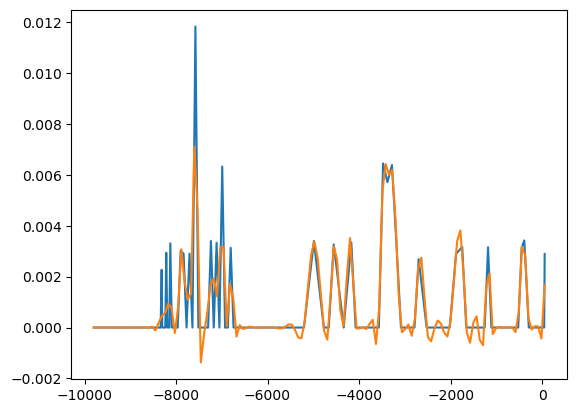

In [59]:
species1 = degrees['node'].iloc[3]
print(species1)
plt.plot(abundances[species1]['prev_x'], abundances[species1]['prev_y'])
plt.plot(abundances[species1]['x'], abundances[species1]['y'])
